# Usage of the API #
$$
\newcommand{\ket}[1]{|#1\rangle}
\newcommand{\bra}[1]{\langle #1|}
$$

This notebook shows how you can use the different functions provided by the module to extend your own scripts and do some research.

In [1]:
from cvxpy import *
import numpy as np
import monogamy as mg

In [2]:
# to avoid clutter, we set the output of floats to a lower precision
np.set_printoptions(precision=9)
np.set_printoptions(suppress=True)

We want to analyse a system in which A and B share a quantum correlation and A and C. The global state $$\rho_{ABC}$$ is thus described by a 8*8 density matrix. Semidef is used to constrain the matrix to be positive-semidefinite.

In [3]:
rho_ABC = Semidef(8)

### Feasible configuration ###
We will analyse the case in which A and B share an EPR-pair

In [4]:
rho_AB = np.array( [ [0.5,0,0,0.5],
                     [0] * 4,
                     [0] * 4,
                     [0.5,0,0,0.5]] )
print(rho_AB)

[[ 0.5  0.   0.   0.5]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.5  0.   0.   0.5]]


The only possible state in which A and C can be is the maximally mixed state, which is completely uncorrelated:

In [5]:
rho_AC = np.diag([0.25] * 4)
print(rho_AC)

[[ 0.25  0.    0.    0.  ]
 [ 0.    0.25  0.    0.  ]
 [ 0.    0.    0.25  0.  ]
 [ 0.    0.    0.    0.25]]


Our goal is now to find the density matrix of the global state of all three systems. This can be done by setting up the following semi-definite optimization problem:
$$
\begin{align*}
\text{minimize}\quad &1 \\
\text{subject to}\quad &tr(\rho_{ABC}) = 1 \\
& \rho_{ABC} \geq 0 \\
&tr_{C}(\rho_{ABC}) = \rho_{AB}^{input} \\
&tr_{B}(\rho_{ABC}) = \rho_{AC}^{input}
\end{align*}
$$
[CVXPY](http://cvxpy.readthedocs.org/en) is able to solve this problem, given you provide it the correct expressions for the constraints and the objective function.

In [6]:
# trace of rho_ABC needs to be 1
constr = [trace(rho_ABC) == 1]

In order to give the partial trace constraints, we have to give the global state, the marginals and a description about which subsystems are traced out. For example, the constraint describing the marginal for tracing out the last system C is described by given the list in which we mark the 3rd index with True. In general, each subsystem that we want to trace out have to be marked with True, the others with false. The last parameter describes the dimension of each subsystem. As we have only qubits in this example, the dimension for A,B and C is 2.

In [7]:
# each entry of matrix rho_ABC must fullfil an equality constraint
constr += mg.partial_trace_constraints(rho_ABC, rho_AB, [False,False,True], [2,2,2])
constr += mg.partial_trace_constraints(rho_ABC, rho_AC, [False,True,False], [2,2,2])

In [8]:
# we only search conditions so we do not need to define an objective
obj = Minimize(1)

In [9]:
# define problem
prob = Problem(obj, constr)

The next step calls a solver to solve the optimization problem. It will output the optimal value, which is only a dummy in our case and has no meaning.

In [10]:
prob.solve()

1.0

If a solution was found, the solver will return "optimal". If no solution exists (which means that the quantum correlations can not coexist) the solver will return "infeasible" (more information about [different problem statuses](http://cvxpy.readthedocs.org/en/latest/tutorial/intro/index.html#other-problem-statuses))

In [11]:
print(prob.status)

optimal


This is how you obtain the global state:

In [12]:
if prob.status == OPTIMAL:
    print(rho_ABC.value)
    sol_ABC = np.array(rho_ABC.value)
else:
    print("There was no solution found, solver returned: ", prob.status)

[[ 0.25  0.    0.    0.    0.    0.    0.25  0.  ]
 [ 0.    0.25  0.    0.    0.    0.    0.    0.25]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.25  0.    0.    0.    0.    0.    0.25  0.  ]
 [ 0.    0.25  0.    0.    0.    0.    0.    0.25]]


The module contains some functions in order to help you analyse density operators. In particular, you can check for a matrix if it is positive semi-definite and if it is a valid density operator:

In [13]:
if prob.status == OPTIMAL:
    print("Solution positive-semidefinite? ->", mg.is_psd(sol_ABC))
    print("Solution valid density operator? ->", mg.is_density_operator(sol_ABC))


Solution positive-semidefinite? -> True
Solution valid density operator? -> True


As we have the global state now, we can check if the partial trace equals with our inputs. The partial trace function takes similar parameters as the partial trace constraints function. We report the sum of squared errors between the matrix-elements as a measure for precision:

In [14]:
if prob.status == OPTIMAL:
    sol_AB = mg.partial_trace(sol_ABC,[False,False,True],[2,2,2])
    sol_AC = mg.partial_trace(sol_ABC,[False,True,False],[2,2,2])
    print(sol_AB)
    print(sol_AC)
    print("SSE for AB: ", np.sum((sol_AB - rho_AB)**2))
    print("SSE for BC: ", np.sum((sol_AC - rho_AC)**2))  

[[ 0.5  0.   0.   0.5]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.5  0.   0.   0.5]]
[[ 0.25  0.    0.    0.  ]
 [ 0.    0.25  0.    0.  ]
 [ 0.    0.    0.25  0.  ]
 [ 0.    0.    0.    0.25]]
SSE for AB:  1.89236037186e-19
SSE for BC:  1.73611139841e-21


### Infeasible configuration ###
Let us also analyse the case in which A and B share an EPR-pair, but A and C have a tiny correlation. The theory tells us, that in this case, there should be no valid global state. In order to produce a tine-correlated state between A and C we will use the werner-function with a very little value:

In [15]:
rho_AC_noise = mg.werner(0.02)
print(rho_AC_noise)

[[ 0.255  0.     0.     0.01 ]
 [ 0.     0.245  0.     0.   ]
 [ 0.     0.     0.245  0.   ]
 [ 0.01   0.     0.     0.255]]


We rebuild the optimization problem and try to solve it:

In [16]:
rho_ABC = Semidef(8)
# trace of rho_ABC needs to be 1
constr = [trace(rho_ABC) == 1]
# each entry of matrix rho_ABC must fullfil an equality constraint
constr += mg.partial_trace_constraints(rho_ABC, rho_AB, [False,False,True], [2,2,2])
constr += mg.partial_trace_constraints(rho_ABC, rho_AC_noise, [False,True,False], [2,2,2])
# we only search conditions so we do not need to define an objective
obj = Minimize(1)
# define problem
prob = Problem(obj, constr)
prob.solve()

if prob.status == OPTIMAL:
    print(rho_ABC.value)
    sol_ABC = np.array(rho_ABC.value)
else:
    print("There was no solution found, solver returned: ", prob.status)

There was no solution found, solver returned:  infeasible


As expected, the strong correlation between A and B prevents any entanglement of A and C. Lets see if we can weaken the correlation between A and B such that the problem becomes feasible again. In particular, we want to figure out how the correlation between A and B can get. Instead of using the more atomic calls to the API we will use the construct_global_state function for this purpose. We define a little function for this purpose:

In [17]:
def max_werner(rho_AC_noise, prec=0.001, output=True):
    """ perform binary search to find the parameter for a werner state that
        maximizes entanglement between A and B, given a correlation between A
        and C """
    # parameters for global state construction
    n = 3
    d = [2,2,2]
    
    # parameters for binary search
    l = 0.0
    r = 1.0
    mid_old = 1.0
    mid_new = 0.0
   
    while np.fabs(mid_old - mid_new) > prec:
        mid_old = mid_new
        mid_new = (l + r) / 2.0
        if output:
            print(mid_new)
        rho_AB_noise = mg.werner(mid_new)
        marg1 = (rho_AB_noise, [False, False, True])
        marg2 = (rho_AC_noise, [False, True, False])
        (state, rho_g) = mg.construct_global_state(n,d,[marg1,marg2])
        if state == OPTIMAL:
            l = mid_new
        else:
            r = mid_new
    
    return mid_new

We execute the function with our previous example:

In [18]:
w = max_werner(rho_AC_noise)
print('werner parameter = ', w)
print(mg.werner(w))

0.5
0.75
0.875
0.9375
0.96875
0.984375
0.9921875
0.99609375
0.998046875
0.9990234375
werner parameter =  0.9990234375
[[ 0.499755859  0.           0.           0.499511719]
 [ 0.           0.000244141  0.           0.         ]
 [ 0.           0.           0.000244141  0.         ]
 [ 0.499511719  0.           0.           0.499755859]]


This state has still a high entanglement. We expect to have a degeneration in entanglement, if we raise the noise between A and C:

In [19]:
rho_AC_noise = mg.werner(0.5)
w = max_werner(rho_AC_noise)
print('werner parameter = ', w)
print(mg.werner(w))

0.5
0.75
0.875
0.8125
0.78125
0.796875
0.8046875
0.80859375
0.810546875
0.8095703125
werner parameter =  0.8095703125
[[ 0.452392578  0.           0.           0.404785156]
 [ 0.           0.047607422  0.           0.         ]
 [ 0.           0.           0.047607422  0.         ]
 [ 0.404785156  0.           0.           0.452392578]]


Interesting! Let us create a plot that shows the maximal entanglemed werner state parameter w_ent given a noise parameter w_noise.


In [20]:
# NOTE: Executing this might take some time...
x = np.linspace(0,1,50)
y = [max_werner(mg.werner(x_c), output=False) for x_c in x]

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

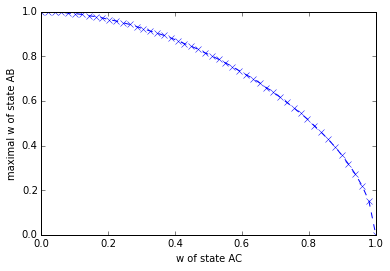

In [22]:
plt.plot(x,y,'x--')
plt.xlabel('w of state AC')
plt.ylabel('maximal w of state AB')

In fact, the entropy of the state between A and B can be (crudely) approximated by a linear function:

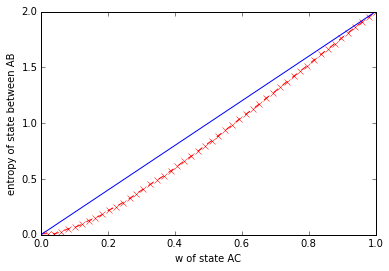

In [23]:
plt.plot(x,[mg.entropy(mg.werner(y_c)) for y_c in y],'xr--')
plt.plot([0,1],[0,2], 'b-')
plt.xlabel('w of state AC')
plt.ylabel('entropy of state between AB')